In [1]:
# <!-- collapse=True -->
%matplotlib inline
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# Import User + Movie baseline model
from cf_utils import DampedUserMovieBaselineModel
from cf_utils import get_rating_matrix

# Use custom matplotlib stylesheet
plt.style.use('./big-darkgrid.mplstyle')

# 2. Load the Data

Let's load and examine the ratings data. If you're following along (i.e. actually running these notebooks) you'll need to make sure to run the first one to download the data before running this one.

In [2]:
# <!-- collapse=True -->
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep='\t', header=None, 
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,userId,movieId,rating,timestamp
214,259,255,4,1997-09-19 23:05:10
83965,259,286,4,1997-09-19 23:05:27
43027,259,298,4,1997-09-19 23:05:54
21396,259,185,4,1997-09-19 23:06:21
82655,259,173,4,1997-09-19 23:07:23



Last 5:


,userId,movieId,rating,timestamp
46773,729,689,4,1998-04-22 19:10:38
73008,729,313,3,1998-04-22 19:10:38
46574,729,328,3,1998-04-22 19:10:38
64312,729,748,4,1998-04-22 19:10:38
79208,729,272,4,1998-04-22 19:10:38


# 3. Write SGDRecommender

In [3]:
# <!-- collapse=True -->
class SGDRecommender():
    """Stochastic Gradient Descent recommender.
    
    Parameters
    ----------
    k : int, default=5
        Number of latent features
    learning_rate : float, default=0.1
        Speed at which to descend down gradient
    max_epochs : int, default=15
        Max number of iterations to run
    error_metric : string, default='mae'
        Error metric to use
    user_reg : float, default=0.0
        Regularization parameter for the latent feature weights in U, >=0
    item_reg : float, default=0.0
        Regularization parameter for the latent feature weights in I, >=0
    user_bias_reg : float, default=0.0
        Regularization parameter for the b_u terms, >=0
    item_bias_reg : float, default=0.0
        Regularization parameter for the b_i terms, >=0
    damping_factor : float, default=25
        Damping factor to be used in the baseline algorithm
    minibatch_size : int, default=1
        Number of user/item pairs to evaluate at a time during training
    verbose : boolean, default=True
        If True, print progress.
    """
    def __init__(self, k=5, learning_rate=0.1, max_epochs=15, error_metric='mae',
                 user_reg=0.0, item_reg=0.0, user_bias_reg=0.0, item_bias_reg=0.0,
                 damping_factor=25, minibatch_size=1, verbose=True):
        self.k = k
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.error_metric = error_metric
        self.user_reg = user_reg
        self.item_reg = item_reg
        self.user_bias_reg = user_bias_reg
        self.item_bias_reg = item_bias_reg
        self.damping_factor = damping_factor
        self.minibatch_size = minibatch_size
        self.verbose = verbose

        self.U = None
        self.I = None
        self.initialized = False

    def _calc_train_error(self, U, I, mu, b_u, b_i, R, R_selector=None):
        if R_selector is None:
            R_selector = (R > 0)
        R_hat = np.dot(U, I.T) + mu + b_u[:, None] + b_i[None, :]
        if self.error_metric == 'mae':
            error = np.sum(R_selector * np.abs(R_hat - R)) / np.sum(R_selector)
        else:
            raise ValueError("{} is an unsupported error metric".format(metric))
        return error

    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        user_col, item_col, rating_col = X.columns[:3]
        self.baseline_algo = DampedUserMovieBaselineModel(damping_factor=self.damping_factor)
        self.baseline_algo.fit(X)
        self.mu = X[rating_col].mean()
        self.b_u, self.b_i = self.baseline_algo.b_u.values, self.baseline_algo.b_i.values
        self.R, self.user_map, self.item_map = get_rating_matrix(X)
        n_users, n_items = self.R.shape
        self.U = np.random.normal(scale=1.0/self.k, size=(n_users, self.k))
        self.I = np.random.normal(scale=1.0/self.k, size=(n_items, self.k))
        self.epoch = 0
        self.train_errors = []
        self.initialized = True

    def fit(self, X, n_epochs=None):
        """Fit model to training data X. If at least one iteration has already been run,
        then the model will continue from its most recent state.

        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        n_epochs : int, optional
            Number of iterations to run. If not provided, will run for self.max_epochs

        Returns
        -------
        self
            This allows chaining like `SGDRecommender().fit(X_train).predict(X_test)`
        """
        X = X.copy()
        # Allow continuation from previous state if n_epochs is given. Otherwise start from scratch.
        if n_epochs is None:
            self.initialized = False
        if not self.initialized:
            self._fit_init(X)
        X.iloc[:, 0] = X.iloc[:, 0].map(self.user_map)
        X.iloc[:, 1] = X.iloc[:, 1].map(self.item_map)

        epoch_0 = self.epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0

        n_users, n_items = self.R.shape

        # Repeat until convergence
        for i_epoch in range(n_epochs):
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # Shuffle X
            X = X.sample(frac=1)
            if self.minibatch_size == 1:
                for row in X.itertuples():
                    index, user, item, rating = row[:4]
                    pred = self.predict_1_train(user, item)
                    err = pred - self.R[user, item]
                    self.b_u[user] -= self.learning_rate * (err + self.user_bias_reg * self.b_u[user])
                    self.b_i[item] -= self.learning_rate * (err + self.item_bias_reg * self.b_i[item])
                    self.U[user, :] -= self.learning_rate * (
                        err * self.I[item, :] + self.user_reg * self.U[user, :]
                    )
                    self.I[item, :] -= self.learning_rate * (
                        err * self.U[user, :] + self.item_reg * self.I[item, :]
                    )
            else:
                raise ValueError("Minibatch size greater than 1 not supported yet.")
            error = self._calc_train_error(self.U, self.I, self.mu, self.b_u, self.b_i, self.R)
            self.train_errors.append(error)
            if self.verbose:
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self

    def predict_1_train(self, user, item):
        pred = self.mu + self.b_u[user] + self.b_i[item]
        pred += np.dot(self.U[user, :], self.I[item, :])
        return pred

    def predict(self, X):
        """Generate predictions for user/item pairs
        
        Parameters
        ----------
        X : pandas dataframe, shape = (n_pairs, 2)
            User, item dataframe
            
        Returns
        -------
        rating_pred : 1d numpy array, shape = (n_pairs,)
            Array of rating predictions for each user/item pair
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        rating_pred = np.array([
            self.predict_1_train(u_ind, i_ind)
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)
        return X['rating'].values

# 4. Determine how many epochs are necessary

In [4]:
# <!-- collapse=True -->
n_splits = 5
max_epochs = 20
k = 20
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
train_errs = np.zeros((n_splits, max_epochs))
test_errs = np.zeros((n_splits, max_epochs))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}".format(i_fold))
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    rec = SGDRecommender(k=k, learning_rate=0.01, user_reg=0.0, item_reg=0.0,
                         user_bias_reg=0.0, item_bias_reg=0.0, max_epochs=max_epochs,
                         damping_factor=10, verbose=False)
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1)
        
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        test_errs[i_fold, i_epoch] = test_err
    train_errs[i_fold, :] = np.array(rec.train_errors)

i_fold=0
i_fold=1
i_fold=2
i_fold=3
i_fold=4


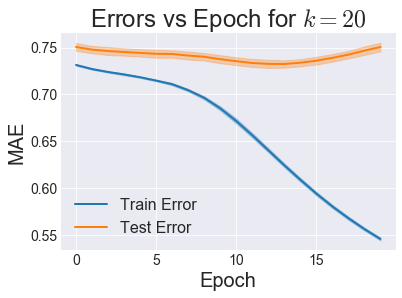

In [5]:
# <!-- collapse=True -->
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.plot(np.arange(max_epochs), train_avg, label='Train Error')
plt.fill_between(np.arange(max_epochs), train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.plot(np.arange(max_epochs), test_avg, label='Test Error')
plt.fill_between(np.arange(max_epochs), test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(r'Errors vs Epoch for $k={}$'.format(k))
plt.show()

# 5. Find Optimal $k$

In [6]:
# <!-- collapse=True -->
n_splits = 5
max_epochs = 12
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
k_list = [1, 5, 10, 20, 50]
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = SGDRecommender(k=k, learning_rate=0.01, verbose=False,
                             max_epochs=max_epochs, damping_factor=10)
        rec.fit(train_df)
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        test_errs[i_fold, i_k] = test_err
        train_errs[i_fold, i_k] = rec.train_errors[-1]
    print()

i_fold=0: k=1, k=5, k=10, k=20, k=50, 
i_fold=1: k=1, k=5, k=10, k=20, k=50, 
i_fold=2: k=1, k=5, k=10, k=20, k=50, 
i_fold=3: k=1, k=5, k=10, k=20, k=50, 
i_fold=4: k=1, k=5, k=10, k=20, k=50, 


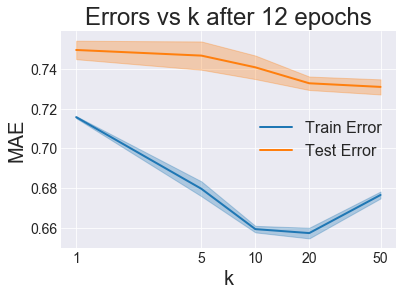

In [7]:
# <!-- collapse=True -->
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.semilogx(k_list, train_avg, label='Train Error')
plt.fill_between(k_list, train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.semilogx(k_list, test_avg, label='Test Error')
plt.fill_between(k_list, test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel('k')
plt.ylabel('MAE')
plt.title(r'Errors vs k after {} epochs'.format(max_epochs))
plt.show()